# Data augmentation

In [1]:
# data = pd.read_csv("Dataset/gridxy.csv", names=['lat', 'lon'])

In [2]:
# data.head()

In [3]:

# plt.figure(figsize=(8,8))
# # plt.plot(lon, lat, '.')
# plt.plot(data['lat'], data['lon'], 'r.')
# plt.title('Sampled grid')
# plt.show()

In [4]:
# def knn(i, df, k_neighbor):
#     data = torch.from_numpy(df.values)
#     test = torch.from_numpy(df.iloc[i].values)

#     dist = torch.norm(data - test, dim=1, p=None)
#     knn = dist.topk(k_neighbor, largest=False)
#     values, indices = knn.values, knn.indices
#     return values, indices

In [5]:
# def trainAugment(data, n_cols=1600):
#   temp = data.copy()
#   dist_arr = []
#   for i in range(n_cols):
#     col_name = "dist"+str(i+1)
#     arr = np.asarray([0]*temp.shape[0])
#     temp[col_name] = arr

#   # print(temp.head())
#   for i in range(temp.shape[0]):
#     # ref = (temp.lat.values[i], temp.lon.values[i])
#     val, indices = knn(i, data, n_cols)
#     val = val.cpu().detach().numpy()
#     indices = indices.cpu().detach().numpy()
#     # print(indices)
#     for j in range(len(indices)):
#       # dist = haversine(ref, (temp.lat.values[indices[j]], temp.lon.values[indices[j]]))
#       dist = val[j]
      
#       col_name = "dist"+str(j+1)
#       temp.loc[i, col_name] = dist
#   temp = temp.iloc[:, 3:]
#   temp['N'] = data['N'].values

#   return temp




In [6]:
# aug_data = trainAugment(data)

In [7]:
# aug_data = aug_data.iloc[:, 1:]
# aug_data.head()

In [8]:
# aug_data.to_csv("Dataset/AugDataN.csv", index = False)

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import torch
# import skgstat as skg
import torch.nn as nn
# import geopandas as gpd 
import plotly.express as px
import torch.nn.functional as F
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

from sklearn.metrics import r2_score
import seaborn as sns

plt.rcParams['figure.figsize'] = (6,5)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [11]:
data = pd.read_csv("Dataset/CleanedK.csv")

In [12]:
data.head()

,lat,lon,K
0,17.894722,73.401111,0.591234
1,17.894722,73.401389,0.187685
2,17.894722,73.402222,0.225866
3,17.894722,73.403056,0.676584
4,17.894722,73.403333,0.263302


In [13]:
data.corr()

,lat,lon,K
lat,1.000000,0.188571,-0.157755
lon,0.188571,1.000000,-0.246754
K,-0.157755,-0.246754,1.000000


## Data PreProcessing

In [14]:
#drop duplicates rows
data.drop_duplicates(subset=['lat', 'lon'], inplace = True)
data = data.reset_index(drop = True)
data.head()

,lat,lon,K
0,17.894722,73.401111,0.591234
1,17.894722,73.401389,0.187685
2,17.894722,73.402222,0.225866
3,17.894722,73.403056,0.676584
4,17.894722,73.403333,0.263302


In [15]:
data.shape

(25724, 3)

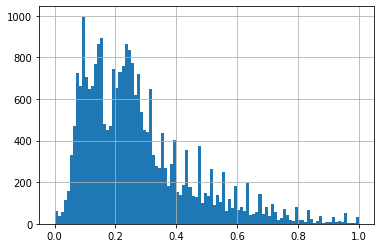

In [16]:
#visually check the distribution of data
data['K'].hist(bins = 100)
plt.show()

<AxesSubplot:xlabel='K'>

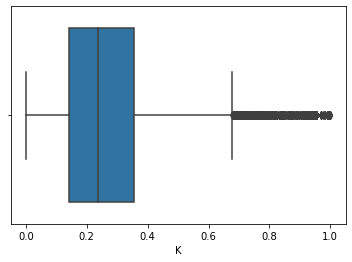

In [17]:
#create a boxplot to see whether there are outliers in the data or not.
sns.boxplot('K',data = data)

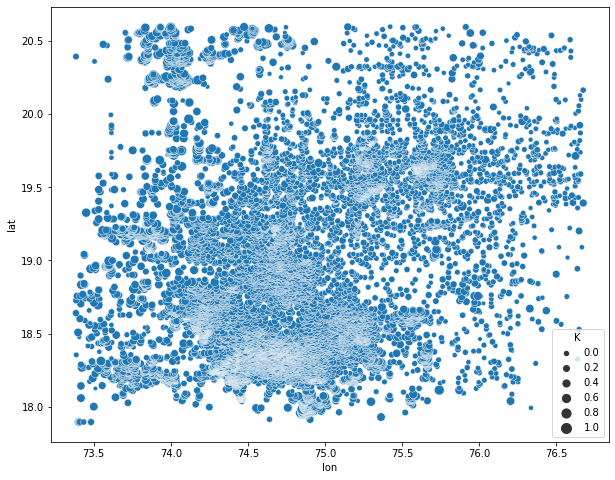

In [18]:
# scatetr plot to see the spatial distribution of the data
plt.figure(figsize=(10, 8))
sns.scatterplot(x ='lon', y ='lat',size ='K',sizes =(20, 100), data = data)
plt.show()

In [19]:
## Desnity plot
fig = px.density_mapbox(data, lat='lat', lon='lon', z='K', radius=8,
                         zoom=7,
                        mapbox_style="stamen-terrain", height=800)
fig.show()

### Split the data (80/20)

In [20]:
# split the data
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.25, random_state=0, shuffle = True)
test, val = train_test_split(test, test_size=0.20, random_state=0, shuffle=True)
print(f"Train shape: {train.shape}\nTest shape: {test.shape}\nValidation shape:{val.shape}")

Train shape: (19293, 3)
Test shape: (5144, 3)
Validation shape:(1287, 3)


In [21]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
# train.head()

## Krigging

**Assumptions for Ordianry Krigging:**
1. Isotropy -  spatial data only depends on the distance separating them.
2. Spatial autocorrelation
3. Stationarity -  mean and variance is constant across the spatial field.

**Auto-correlation**\
Spatial auto-correaltion helps us to establish a relationship between neighbouring data. \
 We will use *morans'I* test to estimate the spatial autocorrelation. 



In [22]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(train.lon, train.lat)]
df = train.copy().drop(['lon', 'lat'], axis=1)
gdf_ = GeoDataFrame(df, crs="EPSG:7767", geometry=geometry)
gdf_.head()

,K,geometry
0,0.244545,POINT (73.859 19.074)
1,0.094715,POINT (75.752 19.504)
2,0.343499,POINT (74.557 18.269)
3,0.265734,POINT (74.958 19.947)
4,0.148625,POINT (74.369 18.289)


In [23]:
# Moran's I test for global spatial autocorrelation
# Hypothesis:
# Null :  There is no global spatial autocorrelation
# Alternate :  There is spatial autocorrelation present among the datapoints
from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot

# queen continuity based spatial weights
y = gdf_['K'].values

w = Queen.from_dataframe(gdf_)
moran = Moran(y, w)

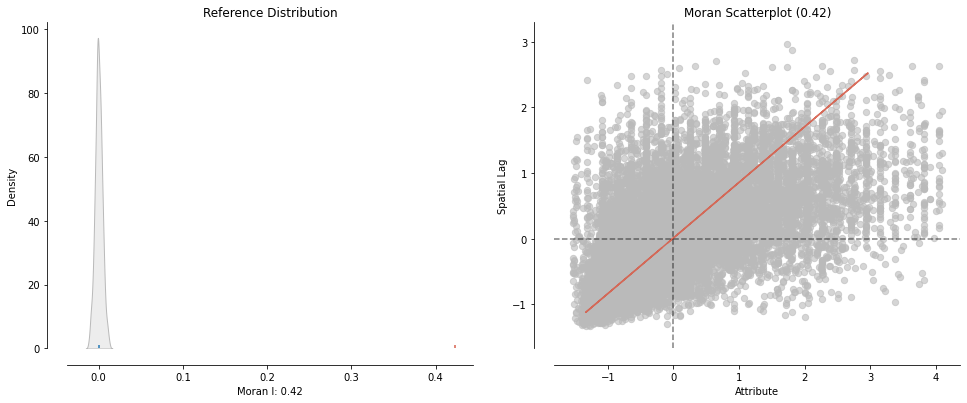

In [24]:
from splot.esda import plot_moran

#visulaize global autocorrelation statistics
plot_moran(moran, zstandard=True, figsize=(16,6))
plt.show()

In [25]:
# let's check for  statistics and p value
stats_, pval_ = moran.I, moran.p_sim
print(f"statstics: {stats_}\np value: {pval_}")

statstics: 0.42263691926651525
p value: 0.001


**Decision:** Since pval is less than than `0.05` (with 95% confidence), we rehect the null hypothesis. There fore autocorrelation exist.

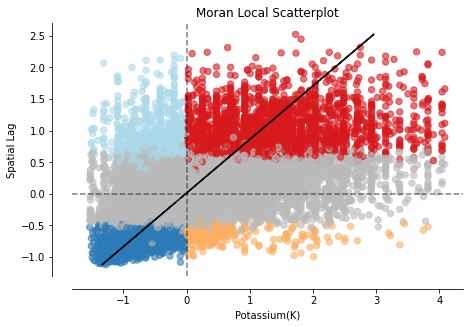

In [26]:
# visualize the local autocorrelation
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Potassium(K)')
ax.set_ylabel('Spatial Lag')
plt.show()

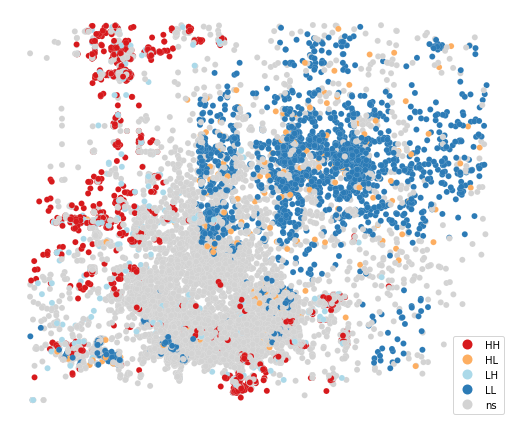

In [27]:
# show the significantly correlated area on the map
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, gdf_, p=0.05, figsize = (9,9))
plt.show()

In the above plot, red dots are corresponding to high autocorrelation of similarity.

#### Stationarity

In [28]:
from skgstat import Variogram, OrdinaryKriging

In [29]:
%%time
#estimate variogram
data_ = train.copy()
lat, lon = data_['lat'].to_numpy(), data_['lon'].to_numpy()
cordinates = np.asarray([(lat[i], lon[i]) for i in range(len(lat))])
variogram = Variogram(cordinates, data_['K'].values,
                          n_lags = 25,
                          maxlag=0.5,
                          model = 'spherical',
                          bin_func='even',
                          use_nugget=True,
                          verbose = True)

CPU times: user 46.8 s, sys: 26.3 s, total: 1min 13s
Wall time: 1min 23s


plotting...


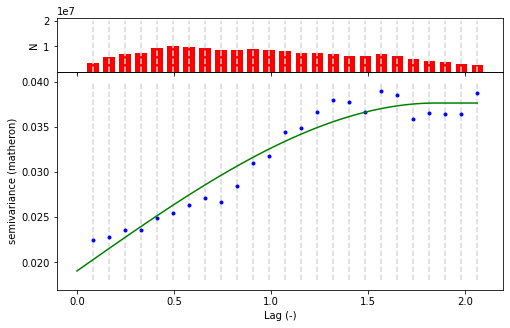

In [30]:
variogram.plot(show = False)
print("plotting...")

In [31]:
# Since the variogram
range_, sill, nugget = variogram.parameters
print(f"Range: {range_}\nsill: {sill}\nnugget: {nugget}")

Range: 1.8497455783399634
sill: 0.01860931815123866
nugget: 0.01905223279336435


since the variogram is bounded(sill defined), therefore no trend is there is the data, so we can that there is stationarity in the data.

In [32]:
data.lat.min(), data.lat.max()

(17.89472222, 20.59805556)

In [33]:
data.lon.min(), data.lon.max()

(73.38416667, 76.67527778)

In [34]:
from skgstat import  OrdinaryKriging

In [35]:
## Ordiinary kriging
ok = OrdinaryKriging(variogram, min_points=1, max_points=15, mode='exact')

In [ ]:
xx, yy = np.mgrid[17:21:500j, 73:77:500j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)

In [ ]:
def interpolate(V, model, field):
#     xx, yy = np.mgrid[18:21:500j, 73:77:500j]
#     field = model.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, field, vmin = 0, vmax=1, cmap='viridis')
    plt.title('%s model' % V.model.__name__)
    plt.colorbar()
    return field

In [ ]:
%%time
field = interpolate(variogram, ok, field)

In [ ]:
with open("K_krig_interpolation.npy", "wb") as f:
    np.save(f, field)

In [ ]:
%%time
# R2 value
field_pred = ok.transform(test.lat.values, test.lon.values)

In [ ]:
r2 = r2_score(test.K.values, field_pred)
r2

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
mae = mean_absolute_error(test.K.values, field_pred)
mae

In [ ]:
mse = mean_squared_error(test.K.values, field_pred)
mse**0.5